<a href="https://colab.research.google.com/github/AhmedFahim-git/Coursera_Capstone/blob/main/IBM_Data_Science_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IBM Data Science Capstone Project

## Introduction

This notebook is used for the IBM Data Science Capstone Project

In [1]:
try:
  import pgeocode
except:
  !pip install pgeocode
  import pgeocode

import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import pgeocode
import requests

!pip install geopy -U
!pip install sklearn -U
!pip install yellowbrick -U


from geopy.geocoders import Nominatim
import folium

import matplotlib.cm as cm
import matplotlib.colors as colors

     |████████████████████████████████| 112kB 5.3MB/s 
  Found existing installation: geopy 1.17.0
    Uninstalling geopy-1.17.0:
      Successfully uninstalled geopy-1.17.0
Requirement already up-to-date: sklearn in /usr/local/lib/python3.7/dist-packages (0.0)
     |████████████████████████████████| 276kB 7.0MB/s 
  Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1


In [2]:
print('Hello Capstone Project Course!')

Hello Capstone Project Course!


## Week 3
# Segmenting and Clustering Neighborhoods in Toronto

## *Part 1*

First we retrieve the postal code, borough and neighborhoods from the [wikipedia page](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M). And put it into a dataframe.

The easiest way to fetch the table is by pandas [read_html](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_html.html) function. If we check the webpage we are geting the table from, we'll notice that is the only table that starts with the word Toronto.

In [3]:
wiki_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M', match='^Toronto.+')[0]
wiki_df.head()

,0,1,2,3,4,5,6,7,8
0,M1ANot assigned,M2ANot assigned,M3ANorth York(Parkwoods),M4ANorth York(Victoria Village),M5ADowntown Toronto(Regent Park / Harbourfront),M6ANorth York(Lawrence Manor / Lawrence Heights),M7AQueen's Park(Ontario Provincial Government),M8ANot assigned,M9AEtobicoke(Islington Avenue)
1,M1BScarborough(Malvern / Rouge),M2BNot assigned,M3BNorth York(Don Mills)North,M4BEast York(Parkview Hill / Woodbine Gardens),"M5BDowntown Toronto(Garden District, Ryerson)",M6BNorth York(Glencairn),M7BNot assigned,M8BNot assigned,M9BEtobicoke(West Deane Park / Princess Garden...
2,M1CScarborough(Rouge Hill / Port Union / Highl...,M2CNot assigned,M3CNorth York(Don Mills)South(Flemingdon Park),M4CEast York(Woodbine Heights),M5CDowntown Toronto(St. James Town),M6CYork(Humewood-Cedarvale),M7CNot assigned,M8CNot assigned,M9CEtobicoke(Eringate / Bloordale Gardens / Ol...
3,M1EScarborough(Guildwood / Morningside / West ...,M2ENot assigned,M3ENot assigned,M4EEast Toronto(The Beaches),M5EDowntown Toronto(Berczy Park),M6EYork(Caledonia-Fairbanks),M7ENot assigned,M8ENot assigned,M9ENot assigned
4,M1GScarborough(Woburn),M2GNot assigned,M3GNot assigned,M4GEast York(Leaside),M5GDowntown Toronto(Central Bay Street),M6GDowntown Toronto(Christie),M7GNot assigned,M8GNot assigned,M9GNot assigned


As we can see in the dataframe returned above, the rows and columns don't mean anything. Each entry in database consists of the Postal Code as the first 3 letters followed by the borough name, followed by a list of neighborhoods separated by dashes and enclosed in parenthesis. Some entries also have some information after these, but those are ignored.

Some entries in the dataframe contain postal codes that aren't assigned. These entries also conviently the phrase 'Not Assigned' so they can easily be filtered out.

In [4]:
table_contents=[]
rows,cols = wiki_df.shape
for row in range(rows):
    for col in range(cols):
      cell = {}
      text = wiki_df.iloc[row,col]
      if text[3:]=='Not assigned':
          pass
      else:
          cell['PostalCode'] = text[:3]
          cell['Borough'] = (text[3:]).split('(')[0]
          cell['Neighborhood'] = (((((text[3:]).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
          table_contents.append(cell)


df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

print(df.shape)
df.head()

(103, 3)


,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


So far we've got 103 postal codes and 3 columns.

## *Part 2*

Now that we've got the location names and postal codes, we can now find the latitudes and longitudes of these places.

The course recommended using the geocoder module to retrieve the location coordinates from the postal codes. However, I found using the pgeocode module easier and more effective.

The key differences are:


*   There's no rate limit
*   No need to loop until we get the desired value

So I'd also suggest the course instructors to suggest using this module as well rather than geocoder.

In [5]:
nomi = pgeocode.Nominatim('ca')

df[['Latitude','Longitude']] = df.apply(lambda x: nomi.query_postal_code(x['PostalCode'])[['latitude','longitude']], axis=1)
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.7545,-79.3300
1,M4A,North York,Victoria Village,43.7276,-79.3148
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.7223,-79.4504
4,M7A,Queen's Park,Ontario Provincial Government,43.6641,-79.3889


## *Part 3*

The dataframe contains a lot of entries, I'd like to take only a subset of these so that I can limit my API calls.

As the course suggests, I'm only going to be using boroughs that contain the word Toronto.

In [6]:
subset = df.loc[df['Borough'].str.contains('Toronto'),:]
subset.reset_index(inplace=True, drop=True)

print(subset.shape)
subset.head()

(39, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.6572,-79.3783
2,M5C,Downtown Toronto,St. James Town,43.6513,-79.3756
3,M4E,East Toronto,The Beaches,43.6784,-79.2941
4,M5E,Downtown Toronto,Berczy Park,43.6456,-79.3754


So now our dataframe contains only 39 entries.

In [7]:
address = 'Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### Optional: Get data into Neighborhood level rather than Postal Code level

In order to get the into Neighborhood level rather than Postal Code level just run the following two blocks of code.

The Neighborhoods are contained as strings in the Neighborhood column separated by commas. We can use pandas [Series.str.split](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.split.html) function to make it into a list. And then we use pandas [explode](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.explode.html) method to separate into rows.

In [8]:
subset['Neighborhood'] = subset['Neighborhood'].str.split(',')
subset = subset.explode('Neighborhood')

subset['Neighborhood'] = subset['Neighborhood'].str.strip()
subset.reset_index(inplace=True, drop=True)

print(subset.shape)
subset.head()

(74, 5)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,Regent Park,43.6555,-79.3626
1,M5A,Downtown Toronto,Harbourfront,43.6555,-79.3626
2,M5B,Downtown Toronto,Garden District,43.6572,-79.3783
3,M5B,Downtown Toronto,Ryerson,43.6572,-79.3783
4,M5C,Downtown Toronto,St. James Town,43.6513,-79.3756


Now we get the coordinates for each of the neighborhoods.

We didn't manage to find the location of one of the neighborhoods so we flagged it with a value of (90,90) which is well outside of Canada. We will remove this entry afterwards.

In [9]:
def get_lat_lon(ser):
  query = '{}, {}, ON'.format(ser['Neighborhood'],ser['Borough'])
  location = geolocator.geocode(query, country_codes='ca' )
  if location is None:
    query = '{}, ON'.format(ser['Neighborhood'])
    location = geolocator.geocode(query, country_codes='ca' )

    if location is None:
      print(ser)
      print()
      return pd.Series((90,90))
  
  return pd.Series(location[-1])

subset[['Latitude','Longitude']] = subset.apply(get_lat_lon, axis=1)
print(subset.shape)
subset.head()

PostalCode                        M7Y
Borough         East Toronto Business
Neighborhood           Enclave of M4L
Latitude                      43.7804
Longitude                    -79.2505
Name: 73, dtype: object

(74, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,Regent Park,43.660706,-79.360457
1,M5A,Downtown Toronto,Harbourfront,43.640080,-79.380150
2,M5B,Downtown Toronto,Garden District,43.656500,-79.377114
3,M5B,Downtown Toronto,Ryerson,43.658324,-79.378925
4,M5C,Downtown Toronto,St. James Town,43.669403,-79.372704


In [10]:
subset = subset.loc[(subset['Latitude']!=90) & (subset['Longitude']!= 90),:]
subset.reset_index(inplace=True, drop=True)

print(subset.shape)
subset.head()

(73, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,Regent Park,43.660706,-79.360457
1,M5A,Downtown Toronto,Harbourfront,43.640080,-79.380150
2,M5B,Downtown Toronto,Garden District,43.656500,-79.377114
3,M5B,Downtown Toronto,Ryerson,43.658324,-79.378925
4,M5C,Downtown Toronto,St. James Town,43.669403,-79.372704


Next we perform a sanity check on the coordinates returned to make sure we got as expected.

In [11]:
subset.describe()

,Latitude,Longitude
count,73.000000,73.000000
mean,43.661117,-79.397981
std,0.025028,0.051137
min,43.544210,-79.678199
25%,43.647741,-79.414372
50%,43.657761,-79.390504
75%,43.671386,-79.378981
max,43.729199,-79.296712


## *Part 3 (Continued)*

Now we visualize the locations using folium.

In [12]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(subset['Latitude'], subset['Longitude'], subset['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Now we use the Foursquare api to find important venues within a 500 m radius, and their categories.

In [13]:
CLIENT_ID = 'VZESYBXQBCKHREIRGK5TEJRMPS5YJNJNWCNOMTDXU3SNKYQI' # your Foursquare ID
CLIENT_SECRET = 'LLV3EB1FBODSBDE0HF4LXIPDGMWWZAEEVMA0EWDXYZUVQL4D' # your Foursquare Secret
VERSION = '20200605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VZESYBXQBCKHREIRGK5TEJRMPS5YJNJNWCNOMTDXU3SNKYQI
CLIENT_SECRET:LLV3EB1FBODSBDE0HF4LXIPDGMWWZAEEVMA0EWDXYZUVQL4D


We define a function to explore each neighborhood and return a dataframe of important venues.

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()
        results = results["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
toronto_venues = getNearbyVenues(subset['Neighborhood'], subset['Latitude'], subset['Longitude'])

print()
print(toronto_venues.shape)
print()
toronto_venues.head()

Regent Park
Harbourfront
Garden District
Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond
Adelaide
King
Dufferin
Dovercourt Village
The Danforth East
Harbourfront East
Union Station
Toronto Islands
Little Portugal
Trinity
The Danforth West
Riverdale
Toronto Dominion Centre
Design Exchange
Brockton
Parkdale Village
Exhibition Place
India Bazaar
The Beaches West
Commerce Court
Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park
The Junction South
North Toronto West
The Annex
North Midtown
Yorkville
Parkdale
Roncesvalles
Davisville
University of Toronto
Harbord
Runnymede
Swansea
Moore Park
Summerhill East
Kensington Market
Chinatown
Grange Park
Summerhill West
Rathnelly
South Hill
Forest Hill SE
Deer Park
CN Tower
King and Spadina
Railway Lands
Harbourfront West
Bathurst Quay
South Niagara
Island airport
Rosedale
Enclave of M5E
St. James Town
Cabbagetown
First Canadian Place
Underground city
Church an

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Regent Park,43.660706,-79.360457,Regent Park Aquatic Centre,43.660600,-79.361392,Pool
1,Regent Park,43.660706,-79.360457,Sumach Espresso,43.658135,-79.359515,Coffee Shop
2,Regent Park,43.660706,-79.360457,Daniels Spectrum,43.660137,-79.361808,Performing Arts Venue
3,Regent Park,43.660706,-79.360457,Thai To Go,43.663418,-79.360710,Thai Restaurant
4,Regent Park,43.660706,-79.360457,Paintbox Bistro,43.660050,-79.362855,Restaurant


In [16]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adelaide,100,100,100,100,100,100
Bathurst Quay,25,25,25,25,25,25
Berczy Park,100,100,100,100,100,100
Brockton,19,19,19,19,19,19
CN Tower,57,57,57,57,57,57
...,...,...,...,...,...,...
Underground city,100,100,100,100,100,100
Union Station,53,53,53,53,53,53
University of Toronto,28,28,28,28,28,28


In [17]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 293 uniques categories.


Most machine learning algorithms, including clustering, doesn't work with categorical variables. Thus they have to be one-hot encoded to make it into a numerical variable.

In [18]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
toronto_onehot = toronto_onehot[ ['Neighborhood'] + [ col for col in toronto_onehot.columns if col != 'Neighborhood' ] ]

toronto_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Theater,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Night Market,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Physical Therapist,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Racetrack,Ramen Restaurant,Real Estate Office,Record Shop,Restaurant,Rock Climbing Spot,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Syrian Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction

In [19]:
toronto_onehot.shape

(3734, 293)

The data now has relevant variables, however, it still has a venue level granularity (i.e. each row represents a venue). We would like to cluster the neighborhoods, not venues, so aggregate the observations to get the data into the neighborhood level. Here, we are using mean as the aggregating function.

In [20]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Theater,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Night Market,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Physical Therapist,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Racetrack,Ramen Restaurant,Real Estate Office,Record Shop,Restaurant,Rock Climbing Spot,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Syrian Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction

In [21]:
toronto_grouped.shape

(72, 293)

Before going into clustering we check the data to see if it is as expected.

Here we print the top 5 venue category for each neighborhood.

From the results we can see that coffee shops are very popular in most places.

In [22]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide----
         venue  freq
0  Coffee Shop  0.08
1         Café  0.06
2        Hotel  0.06
3          Gym  0.05
4   Restaurant  0.05


----Bathurst Quay----
           venue  freq
0    Coffee Shop  0.16
1           Café  0.12
2  Grocery Store  0.08
3           Park  0.08
4  Boat or Ferry  0.04


----Berczy Park----
                venue  freq
0         Coffee Shop  0.09
1                Café  0.05
2  Seafood Restaurant  0.04
3        Cocktail Bar  0.04
4      Breakfast Spot  0.04


----Brockton----
                   venue  freq
0                    Bar  0.16
1                   Park  0.11
2  Vietnamese Restaurant  0.11
3          Grocery Store  0.11
4               Boutique  0.05


----CN Tower----
              venue  freq
0       Pizza Place  0.09
1             Hotel  0.09
2       Coffee Shop  0.07
3  Baseball Stadium  0.05
4    Scenic Lookout  0.05


----Cabbagetown----
         venue  freq
0   Restaurant  0.08
1         Café  0.08
2  Coffee Shop  0.08
3    Gastropub  0.0

We define a function to determine the most common venue for each location. And then we view the top 10 venues for each neighborhood.

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Café,Hotel,Restaurant,Gym,Japanese Restaurant,Clothing Store,Italian Restaurant,American Restaurant,Gastropub
1,Bathurst Quay,Coffee Shop,Café,Park,Grocery Store,Boat or Ferry,Sculpture Garden,Caribbean Restaurant,Sushi Restaurant,Garden,Bank
2,Berczy Park,Coffee Shop,Café,Seafood Restaurant,Breakfast Spot,Cocktail Bar,Italian Restaurant,Japanese Restaurant,Restaurant,Hotel,Beer Bar
3,Brockton,Bar,Park,Vietnamese Restaurant,Grocery Store,Café,Boutique,Bakery,Korean Restaurant,Portuguese Restaurant,Bus Stop
4,CN Tower,Pizza Place,Hotel,Coffee Shop,Bar,Scenic Lookout,Baseball Stadium,Gym,Bistro,Bookstore,Breakfast Spot


Before clustering its a good idea to check if the data has any inconsistencies that might hamper the clustering process.

In [25]:
neighborhoods_venues_sorted.isna().sum()

Neighborhood              0
1st Most Common Venue     0
2nd Most Common Venue     0
3rd Most Common Venue     0
4th Most Common Venue     0
5th Most Common Venue     0
6th Most Common Venue     0
7th Most Common Venue     0
8th Most Common Venue     0
9th Most Common Venue     0
10th Most Common Venue    0
dtype: int64

The data appears to be fine so we proceed with the analysis.

We are using sklearn KMeans to perform the clustering and KElbowVisualizer of the yellowbrick module to find the optimum number of clusters.

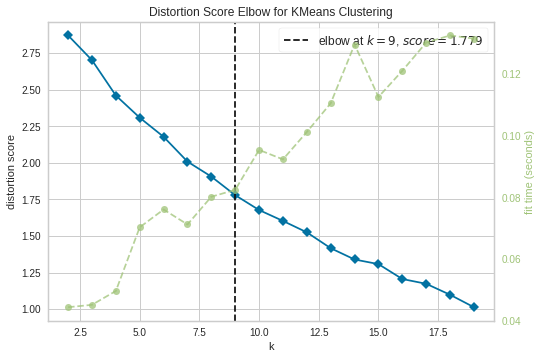

In [49]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,20))


visualizer.fit(toronto_grouped_clustering)        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

From the figure above we can see that the optimum number of clusters is 9. So we fit a final KMeans model using 9 clusters.

In [27]:
# set number of clusters
kclusters = 9

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([6, 6, 6, 7, 0, 0, 6, 3, 7, 0], dtype=int32)

Finally we form a dataframe that has all the relevant information, including the cluster labels that we obtained from KMeans clustering.

In [28]:
# add clustering labels
# neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted['Cluster Labels'] = kmeans.labels_
neighborhoods_venues_sorted = neighborhoods_venues_sorted[ ['Cluster Labels'] + [ col for col in neighborhoods_venues_sorted.columns if col != 'Cluster Labels' ] ]

toronto_merged = subset

# merge toronto_grouped with our subset to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,Regent Park,43.660706,-79.360457,6,Coffee Shop,Thai Restaurant,Restaurant,Indian Restaurant,Auto Dealership,Pub,Food Truck,Pool,Sushi Restaurant,Grocery Store
1,M5A,Downtown Toronto,Harbourfront,43.640080,-79.380150,6,Coffee Shop,Café,Hotel,Restaurant,Pizza Place,Italian Restaurant,Sporting Goods Shop,History Museum,Plaza,Park
2,M5B,Downtown Toronto,Garden District,43.656500,-79.377114,0,Clothing Store,Hotel,Coffee Shop,Movie Theater,Sandwich Place,Theater,Electronics Store,Café,Restaurant,Cosmetics Shop
3,M5B,Downtown Toronto,Ryerson,43.658324,-79.378925,0,Coffee Shop,Clothing Store,Café,Middle Eastern Restaurant,Diner,Falafel Restaurant,Hotel,Japanese Restaurant,Italian Restaurant,Pizza Place
4,M5C,Downtown Toronto,St. James Town,43.669403,-79.372704,6,Coffee Shop,Pizza Place,Café,Grocery Store,Bakery,Bank,Restaurant,Library,Beer Store,Convenience Store


We visualize the different clusters on a map using folium.

In [29]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Below, we inspect the neighborhoods in each cluster, to see if we can interpret them.

The first cluster includes neighborhoods that have many coffee shops or cafes. Most of them have these as the most common venue in the neighborhood.

In [30]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,0,Clothing Store,Hotel,Coffee Shop,Movie Theater,Sandwich Place,Theater,Electronics Store,Café,Restaurant,Cosmetics Shop
3,Downtown Toronto,0,Coffee Shop,Clothing Store,Café,Middle Eastern Restaurant,Diner,Falafel Restaurant,Hotel,Japanese Restaurant,Italian Restaurant,Pizza Place
5,East Toronto,0,Beach,Bar,Japanese Restaurant,Park,Bakery,Pizza Place,Pub,Breakfast Spot,Sandwich Place,Jewelry Store
11,Downtown Toronto,0,Coffee Shop,Clothing Store,Middle Eastern Restaurant,Ramen Restaurant,Tea Room,Café,Italian Restaurant,Cosmetics Shop,Burger Joint,Bubble Tea Shop
14,East York/East Toronto,0,Coffee Shop,Skating Rink,Bus Line,Grocery Store,Pizza Place,Bank,Light Rail Station,Chinese Restaurant,Fried Chicken Joint,French Restaurant
20,East Toronto,0,Coffee Shop,Grocery Store,Bus Line,Caribbean Restaurant,Mexican Restaurant,Doctor's Office,Sushi Restaurant,Fried Chicken Joint,French Restaurant,Bank
25,West Toronto,0,Tibetan Restaurant,Pharmacy,Diner,Pizza Place,Indian Restaurant,Restaurant,Bakery,Accessories Store,Brewery,Bar
26,West Toronto,0,Soccer Stadium,Coffee Shop,Train Station,Poutine Place,Plaza,Athletics & Sports,Arts & Crafts Store,Music Venue,Food Court,Comedy Club
28,East Toronto,0,Beach,Bar,Japanese Restaurant,Park,Bakery,Pizza Place,Pub,Breakfast Spot,Sandwich Place,Jewelry Store
30,Downtown Toronto,0,Coffee Shop,Clothing Store,Middle Eastern Restaurant,Bubble Tea Shop,Burger Joint,Tea Room,Café,Italian Restaurant,Cosmetics Shop,Falafel Restaurant


In [31]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Central Toronto,1,Spa,Playground,Trail,Skating Rink,Yoga Studio,Egyptian Restaurant,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
49,Central Toronto,1,Gym,Playground,Trail,Park,Yoga Studio,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant


In [32]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,West Toronto,2,Park,Dance Studio,Bus Line,Pilates Studio,Farmers Market,Farm,Falafel Restaurant,Ethiopian Restaurant,Escape Room,Doctor's Office


In [33]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
52,Downtown Toronto,3,Mexican Restaurant,Convenience Store,Asian Restaurant,Thrift / Vintage Store,Gas Station,Bus Stop,Yoga Studio,Electronics Store,Dumpling Restaurant,Eastern European Restaurant


In [34]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
57,Central Toronto,4,Playground,Mediterranean Restaurant,Bank,Park,Yoga Studio,Electronics Store,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant


In [35]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Downtown Toronto,5,Theme Park,Pizza Place,Pier,Scenic Lookout,Farm,Playground,Park,American Restaurant,Beer Garden,Beach


In [36]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 6, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,6,Coffee Shop,Thai Restaurant,Restaurant,Indian Restaurant,Auto Dealership,Pub,Food Truck,Pool,Sushi Restaurant,Grocery Store
1,Downtown Toronto,6,Coffee Shop,Café,Hotel,Restaurant,Pizza Place,Italian Restaurant,Sporting Goods Shop,History Museum,Plaza,Park
4,Downtown Toronto,6,Coffee Shop,Pizza Place,Café,Grocery Store,Bakery,Bank,Restaurant,Library,Beer Store,Convenience Store
6,Downtown Toronto,6,Coffee Shop,Café,Seafood Restaurant,Breakfast Spot,Cocktail Bar,Italian Restaurant,Japanese Restaurant,Restaurant,Hotel,Beer Bar
7,Downtown Toronto,6,Coffee Shop,Hotel,Café,Gym,Restaurant,Japanese Restaurant,Clothing Store,Gastropub,American Restaurant,Asian Restaurant
9,Downtown Toronto,6,Coffee Shop,Café,Gastropub,Italian Restaurant,Furniture / Home Store,Grocery Store,Theater,Creperie,Bakery,Cheese Shop
10,Downtown Toronto,6,Coffee Shop,Café,Hotel,Restaurant,Gym,Japanese Restaurant,Clothing Store,Italian Restaurant,American Restaurant,Gastropub
13,West Toronto,6,Café,Pizza Place,Coffee Shop,Bus Line,Bar,Juice Bar,Restaurant,Brazilian Restaurant,Park,Cupcake Shop
15,Downtown Toronto,6,Coffee Shop,Hotel,Restaurant,Japanese Restaurant,Sporting Goods Shop,Bubble Tea Shop,Plaza,Park,Steakhouse,Supermarket
16,Downtown Toronto,6,Coffee Shop,Café,Hotel,Japanese Restaurant,Deli / Bodega,Breakfast Spot,Sporting Goods Shop,Restaurant,Seafood Restaurant,Sandwich Place


In [37]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 7, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Downtown Toronto,7,Korean Restaurant,Coffee Shop,Ice Cream Shop,Cocktail Bar,Sandwich Place,Café,Gift Shop,Mexican Restaurant,Dessert Shop,Grocery Store
12,West Toronto,7,Bar,Bakery,Beer Bar,Beer Store,Restaurant,Vietnamese Restaurant,Café,Mexican Restaurant,Cocktail Bar,Sandwich Place
18,West Toronto,7,Bar,Café,Coffee Shop,Cocktail Bar,Restaurant,Korean Restaurant,Bakery,Portuguese Restaurant,Athletics & Sports,Italian Restaurant
21,East Toronto,7,Vietnamese Restaurant,Chinese Restaurant,Bakery,Bar,Fast Food Restaurant,Grocery Store,Trail,Baseball Field,Chocolate Shop,BBQ Joint
24,West Toronto,7,Bar,Park,Vietnamese Restaurant,Grocery Store,Café,Boutique,Bakery,Korean Restaurant,Portuguese Restaurant,Bus Stop
27,East Toronto,7,Indian Restaurant,Grocery Store,Convenience Store,Café,Diner,Asian Restaurant,Theater,Playground,Brewery,Bar
38,Central Toronto,7,Bar,Coffee Shop,Vegetarian / Vegan Restaurant,Men's Store,Asian Restaurant,Café,Restaurant,Vietnamese Restaurant,Theater,Korean Restaurant
45,Downtown Toronto,7,Café,Park,Bookstore,Japanese Restaurant,Yoga Studio,Italian Restaurant,French Restaurant,Museum,Restaurant,Bar
46,Downtown Toronto,7,Korean Restaurant,Grocery Store,Park,Coffee Shop,Café,Pizza Place,Bar,Karaoke Bar,Dessert Shop,Sandwich Place


In [38]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 8, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
61,Downtown Toronto,8,Circus,BBQ Joint,Athletics & Sports,Golf Driving Range,Music Venue,Pool,Theater,Nightclub,Beach,Boat or Ferry
